In [56]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [80]:
ref_rv = 2400000
lit_period = 51.4213

x, y, yerr = np.loadtxt('data/RV/SONG.txt', usecols=(0,1,2)).T

x += ref_rv
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

In [81]:
import exoplanet as xo

periods = [lit_period]
period_errs = [0.1]
t0s = [2458696.01993447]
t0_errs = [0.1]
Ks = xo.estimate_semi_amplitude(periods, x * u.day, y * u.km / u.s, yerr * u.km / u.s, t0s=t0s) / 1e3
print(Ks, "km/s")

[27.74704468] km/s


In [202]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=1)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=1,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=1, testval=np.log(Ks)
    )
    
    # Systemic velocity
    gammav = pm.Flat("gammav", testval=-13.)

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=1, testval=np.array([0.4])
    )
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK), output_units='km/s') + gammav
        pm.Deterministic("vrad" + name, vrad)

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad#tt.sum(vrad, axis=-1)
                               )

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    
    pm.Normal("obs", mu=rv_model, 
              sd=err, 
              observed=y)
    
    print(xo.eval_in_model(rv_model))

[ -4.34021046  12.83073609 -19.39070215 -28.29116744 -29.38856339
 -29.57117168 -29.6396023  -29.63433659 -29.04987054 -26.86820576
 -25.01065668 -23.87834626 -22.27578678 -20.99034062 -19.16361577
  -0.49571078   4.44382377   9.37654482 -11.00286258 -13.4973486
 -16.01889633 -25.63454031 -26.52483689 -27.94764195 -28.48226956
 -28.90780627 -29.24076451 -29.46414775 -29.22576692 -28.46224565
 -27.92381855 -27.266513   -26.46375349 -25.57440149 -24.49707395
 -22.9819745  -21.78706547 -13.34672171 -10.34048109  -6.87621913
  -1.57529752   2.92510829   6.86242436  12.31508435  17.55911021
  22.24743829  25.7423888   23.7923503   19.72689521  14.63783714
   9.14805958  -0.84211836  -1.05121428  -1.24582262  -1.37824176
  -1.50883552  -1.62117466  -1.76283818  -1.85059559]


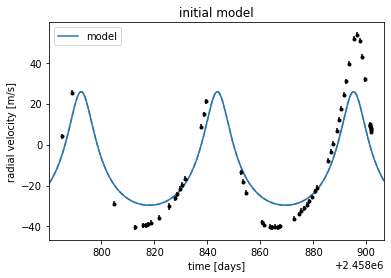

In [203]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")


In [204]:
with model:
    map_soln = xo.optimize(progress_bar=False)

optimizing logp for variables: [logs, omega, ecc, gammav, logK, P, t0]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399.8057768578365 -> -48.01612285072635


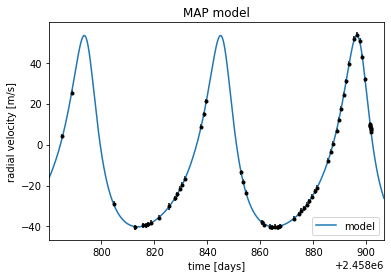

In [205]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
# plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")



In [206]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/daniel/anaconda3/envs/starry/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, omega, ecc, gammav, logK, P, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.


In [207]:
pm.summary(
    trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P"]
)

/home/daniel/anaconda3/envs/starry/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/home/daniel/anaconda3/envs/starry/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logs,-4.984,2.712,-10.003,-0.990,0.046,0.036,3423.0,2895.0,4528.0,3512.0,1.0
omega[0],0.376,0.015,0.348,0.403,0.000,0.000,7842.0,7842.0,7858.0,4741.0,1.0
ecc[0],0.422,0.004,0.414,0.430,0.000,0.000,7992.0,7992.0,7997.0,5096.0,1.0
t0[0],2458696.015,0.091,2458695.841,2458696.189,0.001,0.001,8691.0,8691.0,8727.0,5166.0,1.0
logK[0],3.844,0.007,3.830,3.857,0.000,0.000,8651.0,8648.0,8644.0,5196.0,1.0
P[0],51.437,0.026,51.390,51.488,0.000,0.000,8693.0,8693.0,8734.0,5522.0,1.0


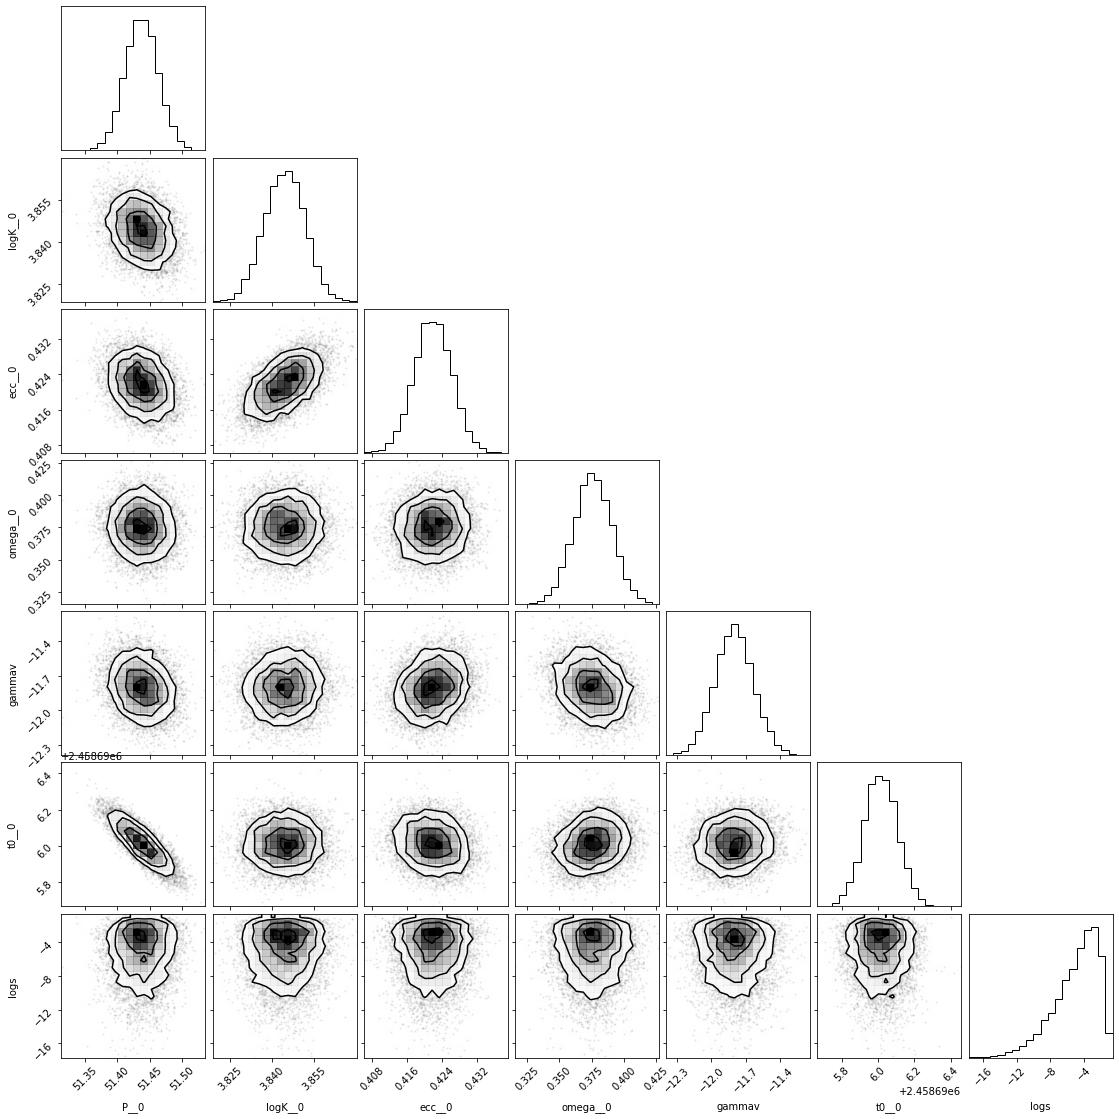

In [208]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega", "gammav", "t0", "logs"])
_ = corner.corner(samples)



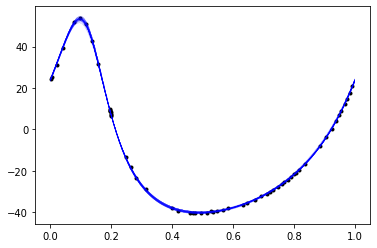

In [214]:
period = np.median(trace["P"], axis=0)

plt.plot(x % period / period, y, '.k')
for i in np.random.choice(len(trace), 50):
    fold = (t) % period / period
    sort = np.argsort(fold)
    plt.plot(fold[sort], trace["rv_model_pred"][i][sort], lw=0.1, c='blue')

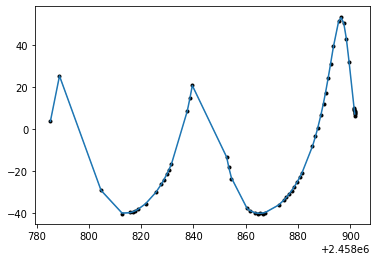

In [212]:
med = np.median(trace["vrad"], axis=0)
sd = np.std(trace["vrad"], axis=0)

plt.plot(x, y, ".k")
plt.plot(x, med)
plt.fill_between(x, med-sd, med+sd, alpha=0.5)

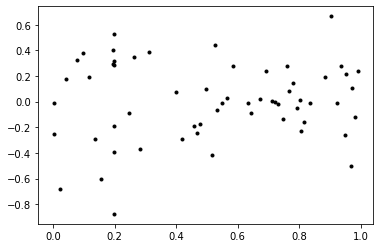

In [213]:
plt.plot(x % period / period, y - med, '.k')

In [50]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
# print(txt)
# print(bib)

